In [1]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import QuantLib as ql


# https://quant.stackexchange.com/questions/44957/numerical-simulation-of-heston-model

In [2]:
theta = 0.132328; kappa = 10.980797; sigma = 1.7; rho = -0.351560; v0 = 0.065690
#spot, K = 659.37, 758.28
spot, K = 659.37, 600.0

In [3]:
feller_cond = 2*kappa*theta > sigma**2
print("Feller condition is ", feller_cond)

Feller condition is  True


In [4]:
def get_aux_params(u, j, theta, kappa, sigma, rho):
    alpha = - u**2 /2. - 1j*u/2. + 1j*j*u
    beta = kappa - rho*sigma*j - rho*sigma*1j*u
    gamma = sigma**2/2
    d = np.sqrt(beta**2 - 4.*alpha*gamma)
    r_p = (beta + d)/sigma**2
    r_n = (beta - d)/sigma**2
    g = r_n/r_p
    return alpha, beta, gamma, d, r_p, r_n, g

In [5]:
alpha, beta, gamma, d, r_p, r_n, g = get_aux_params(1.0, 0.0, theta, kappa, sigma, rho)

In [6]:
# compute auxiliary functions C, D
tau = 1.0
def get_C_D(u, j, tau, theta, kappa, sigma, rho):
    _, _, _, d, _, r_n, g = get_aux_params(u, j, theta, kappa, sigma, rho)
    d_tau = d*tau
    C = kappa*(r_n*tau - 2./sigma**2*np.log((1.-g*np.exp(-d_tau))/(1.-g)))
    D = r_n*(1.-np.exp(-d_tau))/(1.-g*np.exp(-d_tau))
    return C, D

In [7]:
x= np.log(spot/K)
#x=0.05
#u= 0.0
j= 0.0
#C,D = get_C_D(u, j, tau, theta, kappa, sigma, rho)
def get_integrand(v0, x, u, j, tau, theta, kappa, sigma, rho):
    C,D = get_C_D(u, j, tau, theta, kappa, sigma, rho)
    return ((np.exp(C*theta + D*v0 + 1j*u*x)) / (1j*u)).real

def P(v0, x, j, tau, theta, kappa, sigma, rho):
    def wrapper(u):
        return get_integrand(v0,x, u, j, tau, theta, kappa, sigma, rho)    
    
    if tau <= 1e-4:
        tau = 1e-4
    float_epsilon = np.finfo(float).eps
#    print("at 0 ", wrapper(float_epsilon))
#    integral,err =  integrate.quad(wrapper,float_epsilon,2000.0)
    integral,err =  integrate.quad(wrapper,float_epsilon,4000.0)
#    print(err)
    return 0.5 + 1./np.pi * integral
    
def get_call_price(v0, spot, K, tau, theta, kappa, sigma, rho):
    # presume zero risk-free
    x= np.log(spot/K)
    P0 = P(v0, x, 0, tau, theta, kappa, sigma, rho)
    P1 = P(v0, x, 1, tau, theta, kappa, sigma, rho)
    price = spot * P1 - K * P0
    return price

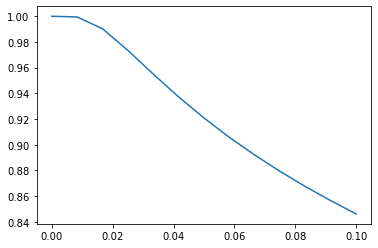

In [8]:
float_epsilon = np.finfo(float).eps
#tau_vec = np.linspace(float_epsilon,0.1,num=100)
tau_vec = np.linspace(float_epsilon,0.1,num=13)
y=[P(v0, x, j, t, theta, kappa, sigma, rho) for t in tau_vec]
plt.plot(tau_vec,y)

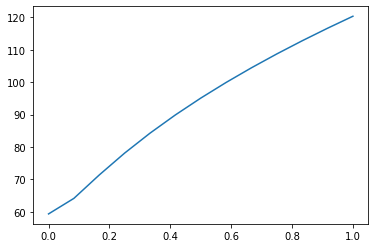

In [9]:
float_epsilon = np.finfo(float).eps
#tau_vec = np.linspace(float_epsilon,0.1,num=100)
tau_vec = np.linspace(float_epsilon,1.,num=13)
price_vec=[get_call_price(v0, spot, K, tau, theta, kappa, sigma, rho) for tau in tau_vec]
plt.plot(tau_vec,price_vec)

In [10]:
tau_vec

array([2.22044605e-16, 8.33333333e-02, 1.66666667e-01, 2.50000000e-01,
       3.33333333e-01, 4.16666667e-01, 5.00000000e-01, 5.83333333e-01,
       6.66666667e-01, 7.50000000e-01, 8.33333333e-01, 9.16666667e-01,
       1.00000000e+00])

In [11]:
price_vec # 44.60563184498372, 32.74999675125653, 20.067667727672358, 7.589426408247249

[59.370000000000005,
 64.16978852269392,
 71.38698153916681,
 78.13235453293026,
 84.27967735147712,
 89.9019164119166,
 95.08912496158922,
 99.9172340134478,
 104.44567200648328,
 108.72043420380896,
 112.77741872358058,
 116.64505306190455,
 120.34620571466837]

# Test using quantlib

In [12]:
# option parameters
strike_price = K
payoff = ql.PlainVanillaPayoff(ql.Option.Call, strike_price)

# option data
maturity_date = ql.Date(8, 5, 2016) # day, month, year
#maturity_date = ql.Date(8, 8, 2015)
spot_price = spot
dividend_rate =  0.0
option_type = ql.Option.Call

risk_free_rate = 0.0
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()

calculation_date = ql.Date(8, 5, 2015)
ql.Settings.instance().evaluationDate = calculation_date

In [13]:
# construct the Heston process

#v0 = volatility*volatility  # spot variance
#kappa = 0.1
#theta = v0
#sigma = 0.1
#rho = -0.75

exercise = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, exercise)

spot_handle = ql.QuoteHandle(
    ql.SimpleQuote(spot_price)
)
flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count)
)
dividend_yield = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count)
)
heston_process = ql.HestonProcess(flat_ts,
                                  dividend_yield,
                                  spot_handle,
                                  v0,
                                  kappa,
                                  theta,
                                  sigma,
                                  rho)

In [14]:
engine = ql.AnalyticHestonEngine(ql.HestonModel(heston_process),0.01, 1000)
european_option.setPricingEngine(engine)
h_price = european_option.NPV()
print("The Heston model price is",h_price)
print("Gatheral ", price_vec[-1])

The Heston model price is 120.46564020700555
Gatheral  120.34620571466837


In [15]:
# data summary
# quantlib
# 44.71315260817815, 33.052730124674554, 20.288685232502672, 7.682417333439105
# Gatheral
# 44.60563184498372, 32.74999675125653, 20.067667727672358, 7.589426408247249

# Validation using Monte-Carlo simulation

In [16]:
def HeMC (S0, mu, v0, rho, kappa, theta, sigma, T, dt):
    xi = sigma

    # Generate a Monte Carlo simulation for the Heston model

    # Generate random Brownian Motion
    MU  = np.array([0, 0])
    COV = np.matrix([[1, rho], [rho, 1]])
    W   = np.random.multivariate_normal(MU, COV, T)
    W_S = W[:,0]
    W_v = W[:,1]

    # Generate paths
    vt    = np.zeros(T)
    vt[0] = v0
    St    = np.zeros(T)
    St[0] = S0
    for t in range(1,T):
#        vt[t] = (vt[t-1] + kappa*(theta-(vt[t-1]))*dt + xi*np.sqrt(dt*vt[t-1])*W_v[t])
        vt[t] = max(0.0,vt[t-1] + kappa*(theta-(vt[t-1]))*dt + xi*np.sqrt(dt*vt[t-1])*W_v[t])
#        vt[t] = np.abs(vt[t-1] + kappa*(theta-(vt[t-1]))*dt + xi*np.sqrt(dt*vt[t-1])*W_v[t])
        St[t] = St[t-1]*np.exp((mu - 0.5*vt[t-1])*dt + np.sqrt(vt[t-1]*dt)*W_S[t])

    return St, vt

In [17]:
num_paths = 10000
payoff_sum = 0.0
T = 252
dt = 1./T
for i in range(num_paths):
    S_last = HeMC (spot, 0.0, v0, rho, kappa, theta, sigma, T, dt)[0][-1]
    payoff = max(0., S_last-K)
    payoff_sum += payoff
payoff_sum /= num_paths
print(payoff_sum)
print(spot, K, v0, rho)

120.90174746912282
659.37 600.0 0.06569 -0.35156


In [18]:
def HestonMC (spot, v0, rho, kappa, theta, sigma, T, dt):
    # Generate a path
    vt    = np.zeros(T)
    vt[0] = v0
    logSt = np.zeros(T)
    logSt[0] = np.log(spot)

    # Milstein scheme for volatility
    for t in range(1,T):
        # Generate random Brownian Motion
        dW_indep = np.random.normal(0.0,1.0,2)
        dW_v = dW_indep[0]
        dW_logS = rho*dW_indep[0] + np.sqrt(1-rho**2)*dW_indep[1] 
        vt[t] = vt[t-1] + kappa*(theta-vt[t-1])*dt + sigma* np.sqrt(vt[t-1]*dt)*dW_v + sigma**2/4.*dt*(dW_v**2-1.)
        if vt[t] < 0.0:
            vt[t] = 0.0
        logSt[t] = logSt[t-1] - vt[t-1]/2.*dt + np.sqrt(vt[t-1]*dt)*dW_logS

    St= np.exp(logSt)
#    St= np.exp(logSt)*spot
    
    return St, vt

In [19]:
num_paths = 10000
payoff_sum = 0.0
T = 252
dt = 1./T
for i in range(num_paths):
    S_last = HestonMC (spot, v0, rho, kappa, theta, sigma, T, dt)[0][-1]
    payoff = max(0., S_last-K)
    payoff_sum += payoff
payoff_sum /= num_paths
print(payoff_sum)
print(spot, K, v0, rho)

119.05006726725428
659.37 600.0 0.06569 -0.35156
